In [12]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

from scipy.linalg import expm

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import UnitaryGate, QFT

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
pi = np.pi

In [18]:
def create_hamiltonian(qubits, g, quiet=False):
    H = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)

    # construct the Hamiltonian
    # with Pauli Operators in Qiskit ^ represents a tensor product
    if not quiet: print("H = ", end='')
    for i in range(qubits-1):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i or j == i+1):
                temp ^= Pauli('Z')
            else:
                temp ^= Pauli('I')
        if not quiet: print("-"+str(temp)+" ", end='')
        H += -temp.to_matrix()
    for i in range(qubits):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i):
                temp ^= Pauli('X')
            else:
                temp ^= Pauli('I')
        if not quiet: print("-"+str(g)+"*"+str(temp)+" ", end='')
        H += -g*temp.to_matrix()
    if not quiet: print("\n")
    
    scale_factor = (3/4) *pi
    # scale eigenvalues of the Hamiltonian
    eigenvalues,_ = np.linalg.eig(H)
    print(eigenvalues)
    H = scale_factor*(H/abs(eigenvalues[-1]))#np.linalg.norm(H, ord=2)
    
    # rotate matrix so that it will be positive definite
    # H += pi*np.eye(2**qubits)

    if not quiet: print("Eigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
    min_eigenvalue = np.min(np.linalg.eigvals(H))
    if not quiet: print("Lowest energy Eigenvalue", min_eigenvalue); print()

    return H

def hadamard_test(ham, t, W = 'Re'):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    qc.x(qr_eigenstate)
    mat = expm(1j*ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    # print(qc)
    aer_sim = AerSimulator()
    trans_qc = transpile(qc, aer_sim)
    Nsample = 1000
    counts = aer_sim.run(trans_qc, shots = Nsample).result().get_counts()
    
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/Nsample
    meas = 2*p0-1
    return meas


In [14]:
data_points = 100
t_list = np.linspace(0, 2*pi, data_points)
# print(t_list)
Dt = 2*pi/data_points
Ham = create_hamiltonian(2,0)
phases = []
for t in t_list:
    # if t == 0: continue
    Re = hadamard_test(Ham, t)


H = -ZZ -0*XI -0*IX 

[-1.+0.j  1.+0.j  1.+0.j -1.+0.j]
Eigenvalues of the Hamiltonian:
 [0.78539816+0.j 5.49778714+0.j 5.49778714+0.j 0.78539816+0.j]
Lowest energy Eigenvalue (0.7853981633974483+0j)



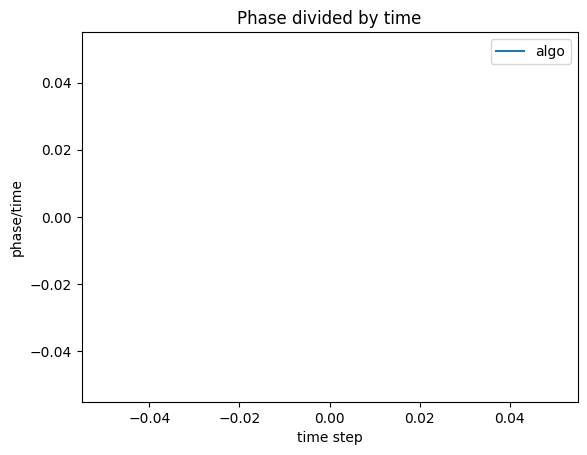

In [15]:
plt.title("Phase divided by time")
plt.xlabel("time step")
plt.ylabel("phase/time")
plt.plot(phases, label = "algo")
# plt.plot(real_phase, label = "expected")
plt.legend()
plt.show()

In [ ]:
def generate_s_k(ham, k, Dt, K):
    # use real hadmard test to generate data
    s_k = [0 for _ in range(2*K+1)]
    for i in range(2*K+1):
        # print("generating s_k for Dt:", (i+1)*Dt)
        s_k[i] = hadamard_test(ham, (i+1)*Dt, W = 'Im')
    # print(s_k)
    # s_k = [1,0,-1,0,1,0,-1,0,1]
    return s_k

def make_X(start, K, d, s_k = []):
    X = np.zeros((d, K+1))
    for i in range(len(X)):
        for j in range(len(X[i])):
            X[i][j] = s_k[i+j+start]
    return X

def least_squares_regularization(X, noise_threshold):
    # print("X", X)
    U, sigma, V = np.linalg.svd(X) # NOTE: V is returned daggered (figured that out way too late)
    threshold = noise_threshold*max(sigma)
    # # check the svd decomp
    # sigma_mat = np.zeros((U.shape[1], V.shape[0]))
    # for l in range(len(sigma)):
    #     sigma_mat[l][l] = sigma[l]
    # print("X after svd\n", U @ sigma_mat @ V)
    # print("sigma", sigma)
    # print("V", V)
    for l in range(len(sigma)):
        # print("iteration")
        # print("sigma_l", sigma[l])
        # if the singular value is too small
        if sigma[l] <= threshold:
            sigma[l] = 0 # remove the value
            U[:,l] = 0 # remove the coorsponding column
            V[l,:] = 0 # remove the coorsponding row
    sigma_mat = np.zeros((U.shape[1], V.shape[0]))
    for l in range(len(sigma)):
        sigma_mat[l][l] = sigma[l]
    # print("U\n", U)
    # print("sigma\n", sigma_mat)
    # print("V\n", V.conj().T)
    return U @ sigma_mat @ V

'''
Dt: time step for each iteration (Dt should not be small)
noise_threshold: used for linear regression
err_threshold: how close the energy until iterations have been stopped
K: number of time steps to take each
alpha: used for calculating d  
est_E_0s: optinal list of collected E_0s
'''

def ODMD(ham, Dt, noise_threshold, err_threshold, K = 3, alpha = 1/2, est_E_0s = []): 
    k = 0
    # this is the suggested formula
    # d = math.floor(alpha*(K+1))
    d=3
    old_E_0 = 10000
    while (True):
        if k*Dt > 2*pi: print("didn't work"); break
        print("k =", k)
        s_k = generate_s_k(ham, k, Dt, K)
        X = make_X(0, K, d, s_k=s_k)
        print("X\n",X)
        Xprime = make_X(1, K, d, s_k=s_k)
        print("Xprime\n",Xprime) 
        X_sigma = least_squares_regularization(X, noise_threshold)
        print("X_sigma\n",X_sigma)  
        A = Xprime @ np.linalg.pinv(X_sigma)
        print("A\n",A)  
        k = k+1
        eigenvalues,_ = np.linalg.eig(A)
        print("eigenvalues\n", eigenvalues)
        # plt.plot(eigenvalues)
        # plt.show()
        # I don't know if I am doing this righadamard_test (I log?)
        # eigenlogs = [math.atan2(i.imag, i.real) for i in eigenvalues]
        # for i in range(len(eigenlogs)):
        #     if eigenlogs[i] == pi: eigenlogs[i] = 0.0
        # print("eigenlogs\n", eigenlogs)
        # plt.plot(eigenlogs)
        # plt.show()
        eigenmax = max(eigenvalues, key=abs)
        print("eigenmax =", eigenmax)
        angle = math.atan2(eigenmax.imag, eigenmax.real)
        print("angle =", angle)
        E_0 = -angle/Dt
        est_E_0s.append(E_0)
        print("E_0 =", E_0)
        if abs(old_E_0 - E_0) < err_threshold: break
        old_E_0 = E_0
    return E_0

Ham = create_hamiltonian(2, 0)
est_E_0s = []
ODMD(Ham, .5, .001, 0.0001, est_E_0s = est_E_0s)

H = -ZZ -0*XI -0*IX 

[-1.+0.j  1.+0.j  1.+0.j -1.+0.j]
Eigenvalues of the Hamiltonian:
 [0.78539816+0.j 5.49778714+0.j 5.49778714+0.j 0.78539816+0.j]
Lowest energy Eigenvalue (0.7853981633974483+0j)

k = 0
X
 [[ 0.926  0.726  0.384  0.   ]
 [ 0.726  0.384  0.    -0.408]
 [ 0.384  0.    -0.408 -0.734]]
Xprime
 [[ 0.726  0.384  0.    -0.408]
 [ 0.384  0.    -0.408 -0.734]
 [ 0.    -0.408 -0.734 -0.914]]
X_sigma
 [[ 9.26000000e-01  7.26000000e-01  3.84000000e-01 -5.47990340e-17]
 [ 7.26000000e-01  3.84000000e-01 -1.27394572e-16 -4.08000000e-01]
 [ 3.84000000e-01  9.93969377e-17 -4.08000000e-01 -7.34000000e-01]]
A
 [[-4.71080194e-16  1.00000000e+00 -5.75082529e-16]
 [-4.93245239e-15  8.92925930e-15  1.00000000e+00]
 [-6.85889412e-01  2.62857324e-01  1.11974632e+00]]
eigenvalues
 [ 0.90591108+0.41277857j  0.90591108-0.41277857j -0.69207585+0.j        ]
eigenmax = (0.9059110828840469+0.41277857327315565j)
angle = 0.4275426952638856
E_0 = 0.8550853905277712
k = 1
X
 [[ 0.938  0.734  0.42  -0

0.8015360261759044

[0.8550853905277712, 0.8909047271562641, 0.7871407687460213, 0.7517503247315535, 0.8871015738289945, 0.7631262483769258, 0.8115478257657305, 0.8285129892489145, 6.283185307179586, 0.7940167968450565, 6.283185307179586, 0.7292268211971709, 0.8015360261759044]


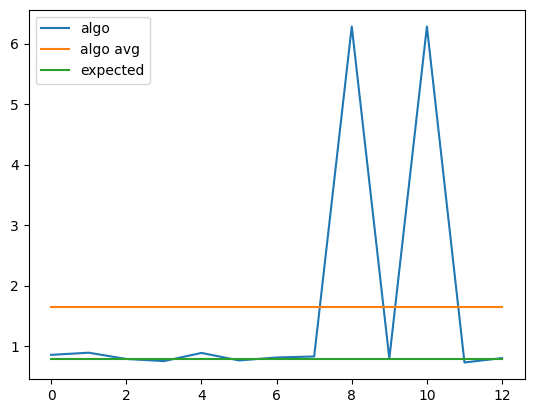

In [17]:
real_E_0 = [np.linalg.eigvals(Ham)[0].real for _ in range(len(est_E_0s))]
avg_E_0 = [np.average(est_E_0s) for _ in range(len(est_E_0s))]
print(est_E_0s)
test = np.array(est_E_0s)

plt.plot(est_E_0s, label = "algo")
plt.plot(avg_E_0, label = "algo avg")
plt.plot(real_E_0, label = "expected")
plt.legend()
# plt.ylim([-(3/4)*pi,(3/4)*pi])
plt.show()